In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, roc_curve, auc

from imblearn.over_sampling import SMOTE
import joblib

# Load CSV - change path if needed
df = pd.read_csv("../data/raw_data.csv")  # or "data/raw_data.csv"
print("Loaded:", df.shape)
df.head()



Loaded: (20600, 27)


,_id,transaction_id,customer_id,transaction_datetime,transaction_amount,merchant_id,merchant_category,payment_method,customer_age,customer_gender,...,ip_risk_score,browser_type,transaction_type,account_type,loan_active_flag,credit_score,monthly_income,previous_fraud_count,transaction_hour,is_fraud
0,69009d180fe950132fd58a78,TXN_015651,CUST_7683,2025-01-06 02:01:29,79.12,M802,Fuel,NetBanking,26.0,Other,...,NaN,Chrome,Online,Credit,0,504.0,50380.36,0,2,0
1,69009d180fe950132fd58a79,TXN_018896,CUST_4228,2025-09-29 22:48:32,3301.18,M970,Grocery,UPI,42.0,Female,...,0.884,Firefox,Online,Current,0,667.0,48503.34,1,22,0
2,69009d180fe950132fd58a7a,TXN_019356,CUST_8801,2024-07-21 12:30:29,5574.78,M696,Electronics,Wallet,27.0,Female,...,0.340,Chrome,POS,Savings,1,631.0,66121.81,0,12,0
3,69009d180fe950132fd58a7b,TXN_017514,CUST_2641,2023-04-07 09:43:27,2363.77,M149,Electronics,UPI,56.0,Male,...,0.548,Edge,ATM,Current,1,673.0,57074.34,0,9,0
4,69009d180fe950132fd58a7c,TXN_018903,CUST_8530,2023-05-23 08:53:12,7648.01,M356,Travel,Credit Card,46.0,Male,...,0.794,Firefox,POS,Current,1,644.0,83979.78,1,8,0


In [10]:

df.shape
df.info()
df.describe(include='all').T
df.isnull().sum().sort_values(ascending=False).head(30)
df.duplicated().sum()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20600 entries, 0 to 20599
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   _id                            20600 non-null  object 
 1   transaction_id                 18968 non-null  object 
 2   customer_id                    20600 non-null  object 
 3   transaction_datetime           20600 non-null  object 
 4   transaction_amount             20600 non-null  float64
 5   merchant_id                    20600 non-null  object 
 6   merchant_category              20600 non-null  object 
 7   payment_method                 20600 non-null  object 
 8   customer_age                   18946 non-null  float64
 9   customer_gender                20600 non-null  object 
 10  customer_location              20600 non-null  object 
 11  device_type                    20600 non-null  object 
 12  is_international               18946 non-null 

np.int64(0)

In [11]:
os.makedirs("../data", exist_ok=True)
df.to_csv("../data/raw_data_backup.csv", index=False)

In [12]:
# Example (if your label column is 'fraudulent' rename it)
# df.rename(columns={'fraudulent':'is_fraud'}, inplace=True)
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
print("Numeric:", num_cols)
print("Categorical:", cat_cols)





Numeric: ['transaction_amount', 'customer_age', 'is_international', 'account_balance_before', 'account_balance_after', 'failed_transaction_count_24h', 'average_transaction_amount_7d', 'ip_risk_score', 'loan_active_flag', 'credit_score', 'monthly_income', 'previous_fraud_count', 'transaction_hour', 'is_fraud']
Categorical: ['_id', 'transaction_id', 'customer_id', 'transaction_datetime', 'merchant_id', 'merchant_category', 'payment_method', 'customer_gender', 'customer_location', 'device_type', 'browser_type', 'transaction_type', 'account_type']


In [13]:
# Example pattern — adapt column names to your dataset
if 'ram' in df.columns.str.lower():
    # if column named 'Ram' with 'GB' suffix
    for c in df.columns:
        if c.lower()=='ram':
            df[c] = df[c].astype(str).str.replace(r'[^0-9.]','', regex=True)
            df[c] = pd.to_numeric(df[c], errors='coerce').astype('Int64')

# generic weight example:
if 'weight' in [c.lower() for c in df.columns]:
    wcol = [c for c in df.columns if c.lower()=='weight'][0]
    df[wcol] = df[wcol].astype(str).str.replace(r'[^0-9.]','', regex=True)
    df[wcol] = pd.to_numeric(df[wcol], errors='coerce')


In [14]:
# 1) For label: drop rows with missing label
df = df[~df['is_fraud'].isna()]

# 2) Numerical columns:
num_cols = df.select_dtypes(include=['number']).columns.tolist()
for col in num_cols:
    pct = df[col].isna().mean()
    if pct < 0.01:
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col + '_missing'] = df[col].isna().astype(int)
        df[col] = df[col].fillna(df[col].median())

# 3) Categorical columns:
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
for col in cat_cols:
    df[col] = df[col].fillna('MISSING')  # keep 'MISSING' as a category

print("✅ Missing values handled safely!")

✅ Missing values handled safely!


In [15]:
before = df.shape[0]
df.drop_duplicates(inplace=True)
after = df.shape[0]
print("Dropped duplicates:", before-after)


Dropped duplicates: 0


is_fraud
0    20447
1      153
Name: count, dtype: int64 is_fraud
0    0.992573
1    0.007427
Name: proportion, dtype: float64


<Axes: >

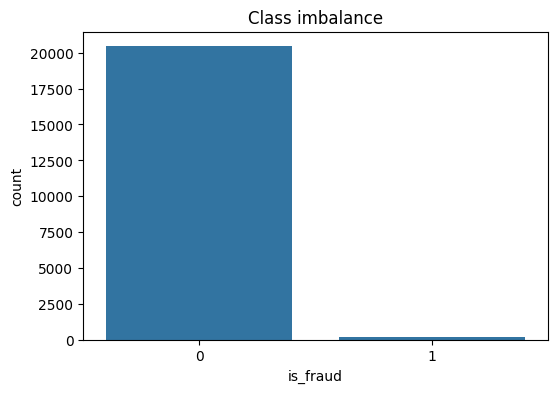

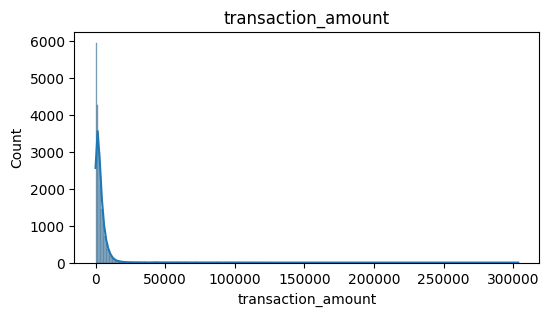

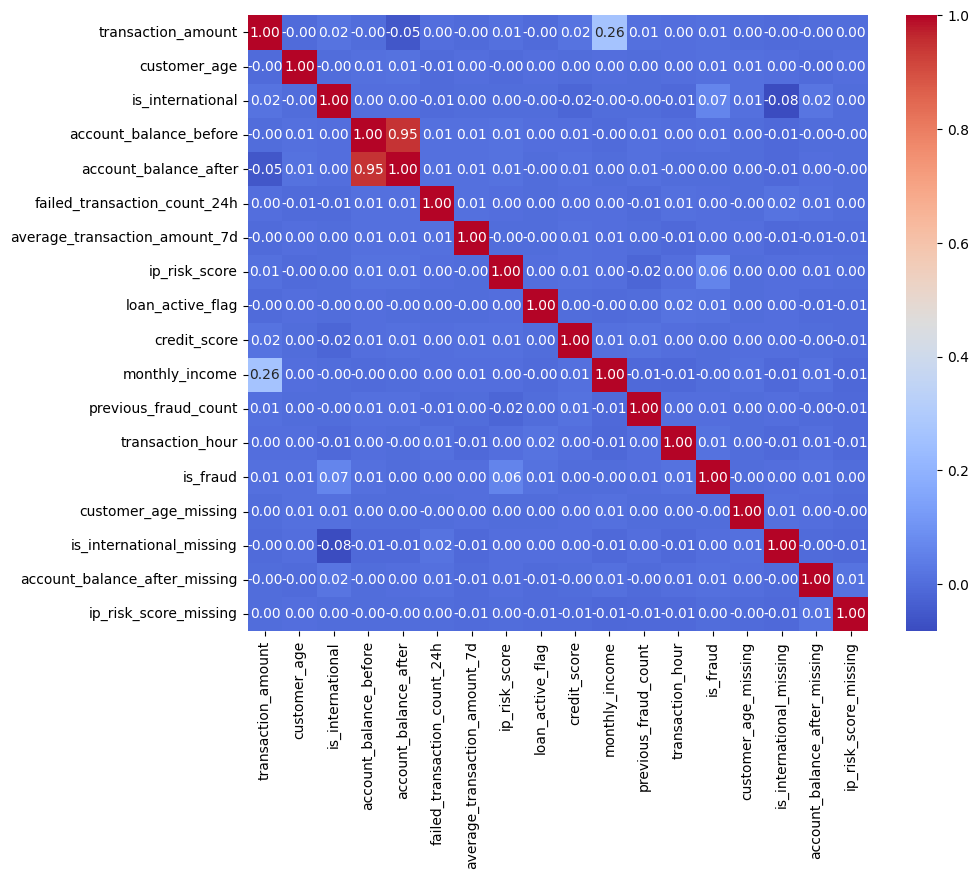

In [16]:
# Class balance
print(df['is_fraud'].value_counts(), df['is_fraud'].value_counts(normalize=True))

# Visuals
plt.figure(figsize=(6,4))
sn.countplot(x='is_fraud', data=df)
plt.title('Class imbalance')

# Distribution of key numeric features
for col in ['transaction_amount','age','time_since_last_tx'][:]:  # replace with your numeric features
    if col in df.columns:
        plt.figure(figsize=(6,3))
        sn.histplot(df[col], kde=True)
        plt.title(col)

# Correlation heatmap for numeric features
numeric_df = df.select_dtypes(include=['number'])
plt.figure(figsize=(10,8))
sn.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')



In [17]:
# Example derived features (adapt field names)
if 'transaction_amount' in df.columns and 'account_balance' in df.columns:
    df['amount_ratio'] = df['transaction_amount'] / (df['account_balance'] + 1)

# Transaction time (if timestamp exists)
if 'transaction_time' in df.columns:
    df['transaction_time'] = pd.to_datetime(df['transaction_time'])
    df['hour'] = df['transaction_time'].dt.hour
    df['dayofweek'] = df['transaction_time'].dt.dayofweek

# Frequency aggregates (need grouping)
if 'customer_id' in df.columns:
    txn_counts = df.groupby('customer_id').size().rename('cust_txn_count')
    df = df.merge(txn_counts, left_on='customer_id', right_index=True, how='left')




In [18]:
# Reduce cardinality for a categorical col
def top_k_replace(df, col, k=20):
    topk = df[col].value_counts().nlargest(k).index
    df[col] = df[col].apply(lambda x: x if x in topk else 'OTHER')
    return df

# Example: compress 'merchant' col
if 'merchant' in df.columns:
    df = top_k_replace(df, 'merchant', k=50)

# Now prepare lists for transformer
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
num_cols = df.select_dtypes(include=['number']).columns.tolist()
num_cols.remove('is_fraud') if 'is_fraud' in num_cols else None

# ColumnTransformer pipeline example (no scaling on OHE)
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'), cat_cols)
], remainder='drop')



In [19]:
X = df.drop(columns=['is_fraud'])
y = df['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y)

print(X_train.shape, X_test.shape, y_train.value_counts(normalize=True))




(16480, 31) (4120, 31) is_fraud
0    0.992597
1    0.007403
Name: proportion, dtype: float64


In [20]:
X_train.select_dtypes(include=['object']).columns
X_train = X_train.drop(['transaction_id', 'customer_id'], axis=1, errors='ignore')
X_test = X_test.drop(['transaction_id', 'customer_id'], axis=1, errors='ignore')
from sklearn.preprocessing import OrdinalEncoder

# drop obvious ID/hash columns first
drop_cols = ['transaction_id', 'customer_id', 'id']  # change names to match your dataset
X_train = X_train.drop(columns=drop_cols, errors='ignore')
X_test = X_test.drop(columns=drop_cols, errors='ignore')

# encode remaining categorical columns safely
cat_cols = X_train.select_dtypes(include=['object']).columns
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train[cat_cols] = oe.fit_transform(X_train[cat_cols].astype(str))
X_test[cat_cols] = oe.transform(X_test[cat_cols].astype(str))

In [21]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("✅ After SMOTE:", y_train_res.value_counts())

✅ After SMOTE: is_fraud
1    16358
0    16358
Name: count, dtype: int64


In [22]:
drop_cols = ['_id', 'customer_id', 'merchant_id', 'transaction_datetime']
X_train = X_train.drop(columns=drop_cols, errors='ignore')
X_test = X_test.drop(columns=drop_cols, errors='ignore')

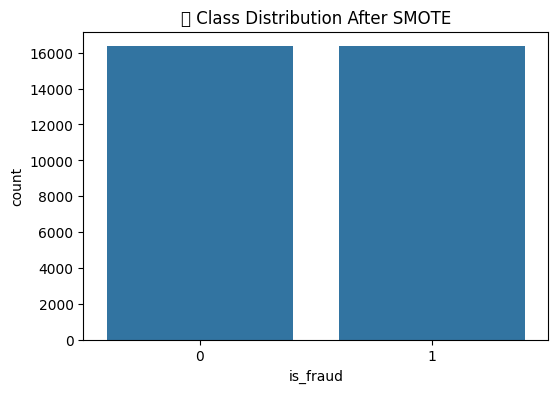

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(x=y_train_res)
plt.title("✅ Class Distribution After SMOTE")
plt.xlabel("is_fraud")
plt.ylabel("count")
plt.show()

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# -------------------------
# Train / Test split
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -------------------------
# Preprocessing (before SMOTE)
# -------------------------
num_cols = X_train.select_dtypes(include=['number']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

# -------------------------
# Fit preprocessor & transform train set
# -------------------------
X_train_enc = preprocessor.fit_transform(X_train)
X_test_enc = preprocessor.transform(X_test)

# -------------------------
# Apply SMOTE AFTER encoding
# -------------------------
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_enc, y_train)

# -------------------------
# Models
# -------------------------
models = {
    'LogReg': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced_subsample'),
    'XGBoost': XGBClassifier(
        eval_metric='logloss',
        scale_pos_weight=(len(y_train_res[y_train_res==0]) / len(y_train_res[y_train_res==1])),
        random_state=42
    )
}

# -------------------------
# Train & Evaluate
# -------------------------
for name, model in models.items():
    print(f"\n===== {name} =====")
    
    model.fit(X_train_res, y_train_res)
    
    preds = model.predict(X_test_enc)
    probs = model.predict_proba(X_test_enc)[:, 1]
    
    print("ROC AUC:", roc_auc_score(y_test, probs))
    print(classification_report(y_test, preds))



===== LogReg =====
ROC AUC: 0.6923295387309778
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4089
           1       0.00      0.00      0.00        31

    accuracy                           0.99      4120
   macro avg       0.50      0.50      0.50      4120
weighted avg       0.99      0.99      0.99      4120


===== RandomForest =====
ROC AUC: 0.6104891960334178
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4089
           1       0.00      0.00      0.00        31

    accuracy                           0.99      4120
   macro avg       0.50      0.50      0.50      4120
weighted avg       0.99      0.99      0.99      4120


===== XGBoost =====
ROC AUC: 0.7027666674555653
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4089
           1       0.00      0.00      0.00        31

    accuracy                   


🔷 Training: Logistic Regression
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4089
           1       0.00      0.00      0.00        31

    accuracy                           0.99      4120
   macro avg       0.50      0.50      0.50      4120
weighted avg       0.98      0.99      0.99      4120

Confusion Matrix:
 [[4076   13]
 [  31    0]]
ROC AUC: 0.692


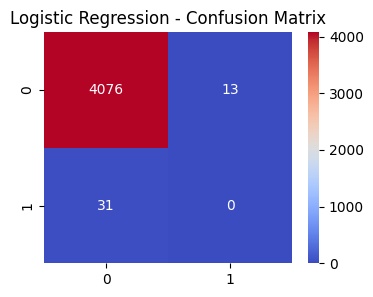

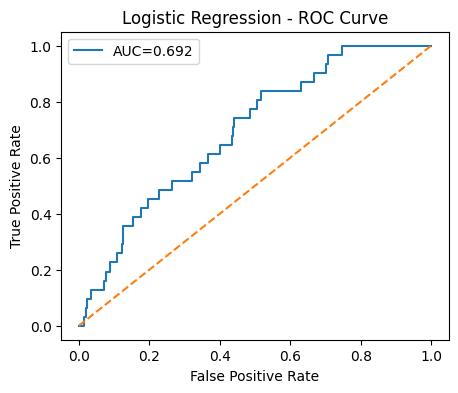


🔷 Training: Random Forest
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4089
           1       0.00      0.00      0.00        31

    accuracy                           0.99      4120
   macro avg       0.50      0.50      0.50      4120
weighted avg       0.99      0.99      0.99      4120

Confusion Matrix:
 [[4089    0]
 [  31    0]]
ROC AUC: 0.610


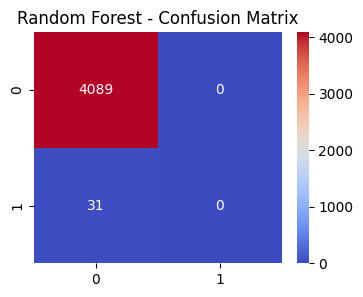

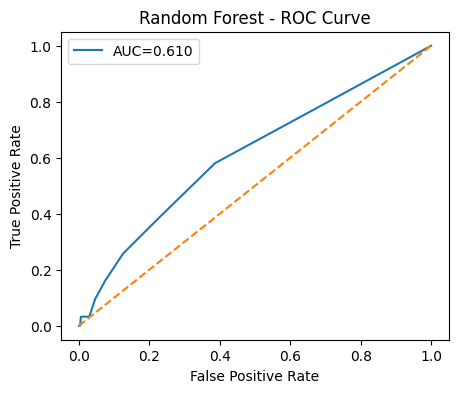


🔷 Training: XGBoost
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4089
           1       0.00      0.00      0.00        31

    accuracy                           0.99      4120
   macro avg       0.50      0.50      0.50      4120
weighted avg       0.99      0.99      0.99      4120

Confusion Matrix:
 [[4089    0]
 [  31    0]]
ROC AUC: 0.703


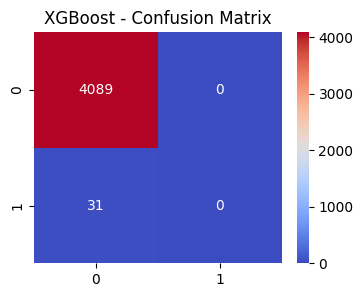

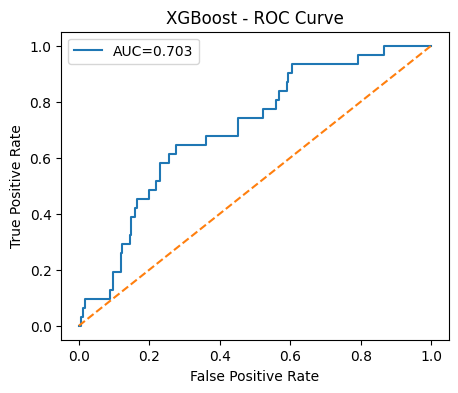


📊 Model Comparison
                 Model  Accuracy   ROC-AUC  Precision (1)  Recall (1)  F1 (1)
0  Logistic Regression  0.989320  0.692330            0.0         0.0     0.0
1        Random Forest  0.992476  0.610489            0.0         0.0     0.0
2              XGBoost  0.992476  0.702767            0.0         0.0     0.0


In [25]:
# ==========================
# ✅ Import Libraries
# ==========================
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, roc_auc_score, classification_report,
                             confusion_matrix, roc_curve)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# ==========================
# ✅ Train/Test Split
# ==========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ==========================
# ✅ Preprocessing
# ==========================
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

# ==========================
# ✅ Define Models in Pipelines (SMOTE inside)
# ==========================
pipelines = {
    "Logistic Regression": ImbPipeline(steps=[
        ('preprocess', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
    ]),

    "Random Forest": ImbPipeline(steps=[
        ('preprocess', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('clf', RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced_subsample'))
    ]),

    "XGBoost": ImbPipeline(steps=[
        ('preprocess', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('clf', XGBClassifier(
            eval_metric='logloss',
            random_state=42
        ))
    ])
}

# ==========================
# ✅ Train, Predict & Evaluate
# ==========================
results = []

for name, model in pipelines.items():
    print(f"\n🔷 Training: {name}")
    model.fit(X_train, y_train)

    y_probs = model.predict_proba(X_test)[:, 1]
    preds = (y_probs > 0.30).astype(int)   # custom threshold

    acc = accuracy_score(y_test, preds)
    auc = roc_auc_score(y_test, y_probs)
    cm = confusion_matrix(y_test, preds)
    cr = classification_report(y_test, preds, output_dict=True)

    results.append({
        'Model': name,
        'Accuracy': acc,
        'ROC-AUC': auc,
        'Precision (1)': cr['1']['precision'],
        'Recall (1)': cr['1']['recall'],
        'F1 (1)': cr['1']['f1-score']
    })

    print(classification_report(y_test, preds))
    print("Confusion Matrix:\n", cm)
    print(f"ROC AUC: {auc:.3f}")

    # Confusion Matrix heatmap
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    # ROC curve plot
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0,1], [0,1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{name} - ROC Curve")
    plt.legend()
    plt.show()

# ==========================
# ✅ Summary Table
# ==========================
results_df = pd.DataFrame(results)
print("\n📊 Model Comparison")
print(results_df)


In [26]:

# ---- Choose best model by ROC-AUC (column name 'ROC-AUC') ----
best_model_name = results_df.sort_values(by='ROC-AUC', ascending=False).iloc[0]['Model']
print(f"\n🏆 Best model by ROC-AUC: {best_model_name}")

# ---- Get the fitted pipeline object for best model ----
best_pipeline = pipelines[best_model_name]


🏆 Best model by ROC-AUC: XGBoost


In [28]:
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score

best_model.fit(X_train, y_train)

probs = best_model.predict_proba(X_test)[:, 1]
preds_default = (probs >= 0.5).astype(int)

print("\nClassification report (default 0.5):")
print(classification_report(y_test, preds_default))

roc_auc = roc_auc_score(y_test, probs)
print("ROC AUC:", roc_auc)

precision, recall, thresholds = precision_recall_curve(y_test, probs)
pr_auc_value = auc(recall, precision)

print("PR AUC:", pr_auc_value)

plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f"PR AUC={pr_auc_value:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"{best_model_name} - Precision-Recall Curve")
plt.legend()
plt.show()


NameError: name 'best_model' is not defined

Chosen threshold: 0.00011076644

Classification report (chosen threshold):
              precision    recall  f1-score   support

           0       1.00      0.41      0.58      4089
           1       0.01      0.90      0.02        31

    accuracy                           0.41      4120
   macro avg       0.50      0.65      0.30      4120
weighted avg       0.99      0.41      0.57      4120



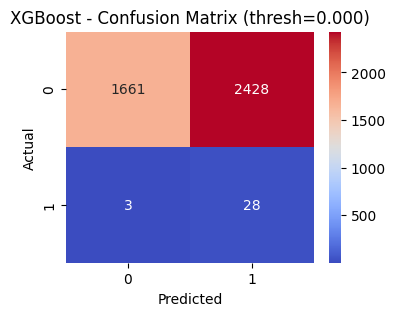

In [ ]:
# ---- Choose threshold where recall >= 0.90 (if possible) ----
# thresholds array length = len(precision)-1; align accordingly
if thresholds.size == 0:
    chosen_thresh = 0.5
else:
    # find last threshold producing recall >= 0.90
    idxs = np.where(recall[:-1] >= 0.90)[0]  # exclude last recall element which corresponds to threshold beyond max
    if idxs.size > 0:
        chosen_thresh = thresholds[idxs[-1]]
    else:
        # fallback: choose threshold that maximizes f1
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-12)
        best_idx = np.nanargmax(f1_scores[:-1])  # ignore the last element
        chosen_thresh = thresholds[best_idx]

print("Chosen threshold:", chosen_thresh)

preds_thresh = (probs >= chosen_thresh).astype(int)
print("\nClassification report (chosen threshold):")
print(classification_report(y_test, preds_thresh))

# Confusion matrix at chosen threshold
cm_thresh = confusion_matrix(y_test, preds_thresh)
plt.figure(figsize=(4,3))
sns.heatmap(cm_thresh, annot=True, fmt='d', cmap='coolwarm')
plt.title(f"{best_model_name} - Confusion Matrix (thresh={chosen_thresh:.3f})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


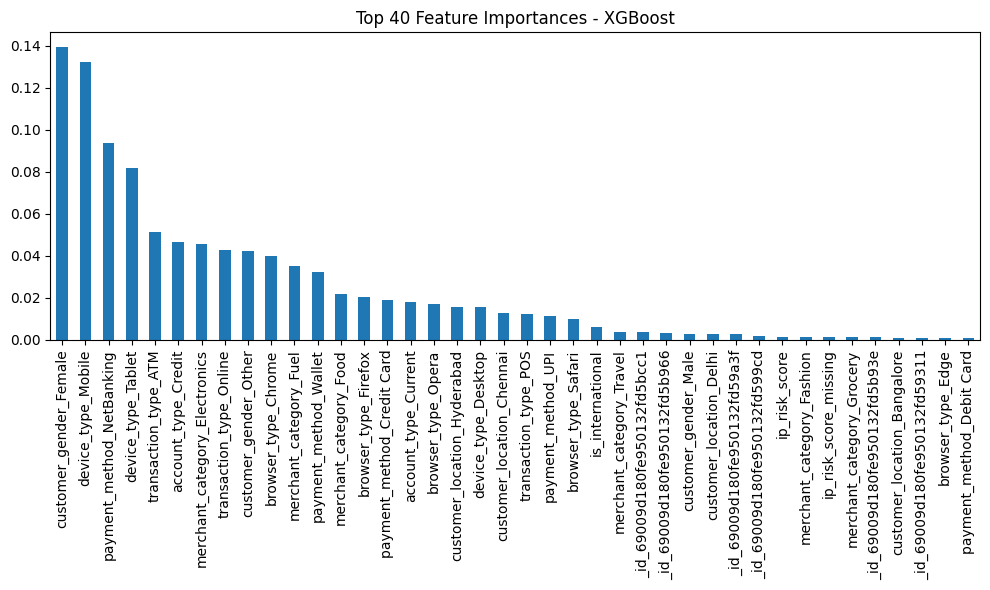

In [29]:

# ---- If best model is XGBoost, extract feature importances safely ----
if best_model_name.lower().startswith('xgboost') or 'xgboost' in best_model_name.lower():
    # get fitted preprocessing transformer (ColumnTransformer)
    pre = best_pipeline.named_steps['preprocess']
    # numeric names
    num_feat_names = num_cols
    # one-hot encoder transformer
    ohe = pre.named_transformers_['cat']
    if hasattr(ohe, "get_feature_names_out"):
        cat_feat_names = list(ohe.get_feature_names_out(cat_cols))
    else:
        # backup naming if older sklearn version
        cat_feat_names = []
        for i, cat in enumerate(cat_cols):
            # cautious fallback: create simple names (not ideal)
            cat_feat_names.append(cat)

    feature_names = np.array(num_feat_names + cat_feat_names)

    xgb_clf = best_pipeline.named_steps['clf']
    importances = xgb_clf.feature_importances_

    if importances.shape[0] == feature_names.shape[0]:
        feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(40)
        plt.figure(figsize=(10,6))
        feat_imp.plot(kind='bar')
        plt.title("Top 40 Feature Importances - XGBoost")
        plt.tight_layout()
        plt.show()
    else:
        print("Warning: feature importances length does not match feature names length.")
        print(f"len(importances)={len(importances)}, len(feature_names)={len(feature_names)}")

In [30]:
# ---- Save best fitted pipeline to disk ----
save_path = "model/fraud_pipeline.pkl"

# Save full pipeline (preprocessing + SMOTE + model)
joblib.dump(best_model, save_path)

print(f"✅ Saved trained pipeline ({best_model_name}) to: {save_path}")


NameError: name 'best_model' is not defined

In [ ]:
import os
os.makedirs("model", exist_ok=True)
